# Exploracíon del dataset
_Santiago Prieto Núñez_

#### Objetivo
En este Jupiter Notebook explporaremos la forma de los datos de distintos dataset
obteniendo su distribución de tamaño de imágen, número de canales de la imágen,
tipo de etiquetado de la misma, ya que podemos tener desde máscaras con la 
localización del pólipo a sencillas etiquetas y cantidad de imágenes de tipo WLI
o NBI. o más tipos si los hubiera.

Los datasets explorados son los siguientes:
- Piccolo Dataset

### Obtención de imágenes
En este apartado obtenemos las imágenes de cada dataset, para ello usaremos la 
siguiente clase para poder cargar y registrar la información del dataset

In [69]:
import os
import cv2
import numpy as np
from enum import Enum
import matplotlib.pyplot as plt
import seaborn as sns

class Dataset:
    def __init__(self):
        # Imágenes del dataset
        self.polyp_img = []         # Paths de imágenes de pólipos
        self.bin_img = []           # Paths de máscaras binarias si existen
        self.void_img = []          # Paths de imágenes de márgenes si existen

        # Información sobre el dataset
        self.format_counts = {}       # Número de imágenes por formato: WLI, NBI ...
        self.function_counts = {}   # Número de imágenes por funcion; test, train ...
        self.resolution_counts = {}   # Conteo de imágenes por resolución
        self.channel_counts = {}      # Conteo de imágenes por número de canales

    def path_load_images(self, directory_path, img_type, img_func, img_format=None):
        """
        Carga los paths de las imágenes de un directorio dado.
        Ordena estas imágenes para poder relacionarlas con sus máscaras
        """
        image_paths = []
        file_names = sorted(os.listdir(directory_path))

        for file in file_names:
            file_path = os.path.join(directory_path, file)
            img = cv2.imread(file_path)
            if img is not None:
                image_paths.append(file_path)
                self._update_stats(img, img_type, img_func, img_format)  # Actualiza estadísticas de la imagen
            else:
                print("Error cargando {}".format(file_path))
                
        return image_paths

    def _update_stats(self, img, img_type, img_func, img_format=None):
        """
        Actualiza la información de imágenes del dataset : 
            resolución, número de canales, número de imagen por tipo ... etc
        """
        # Revisamos los canales de la imágen, shape[2] solo tiene valor si son 3 canales
        channels = str(img.shape[2]) + f"_{img_type}" if len(img.shape) > 2 else f"1_{img_type}"
        if channels not in self.channel_counts:
            self.channel_counts[channels] = 0
        self.channel_counts[channels] += 1

        # Actualizar tipo de imagen, resolución y función por formato solo para imágenes tipo polyp
        if img_type == "polyp":
            # Actualizar resolución
            resolution = f"{img.shape[1]}x{img.shape[0]}"
            if resolution not in self.resolution_counts:
                self.resolution_counts[resolution] = 0      # creamos una nueva entrada en el diccionario
            self.resolution_counts[resolution] += 1

            # Actualizar tipo de imagen por función
            function = f"{img_func}"
            if function not in self.function_counts:
                self.function_counts[function] = 0
            self.function_counts[function] += 1

            # Actualizar formato de imagen si no lo tenemos ya
            format = img_format or f"{self._obtain_img_format(img)}"
            if format not in self.format_counts:
                self.format_counts[format] = 0
            self.format_counts[format] += 1

    def _obtain_img_format(self, img):
        format = "WLI"
        b, g, r = cv2.split(img)
        mean_b, mean_g, mean_r = np.mean(b), np.mean(g), np.mean(r)
        if mean_r < 80.0:   # el único método por ahora
            format = "NBI"
        
        return format


    def load_dataset(self, path, img_type, img_function, img_format=None):
        """
        Carga el conjunto de imágenes dado y actualiza las estadísticas.
        """

        if img_type == "polyp":
            self.polyp_img.extend(self.path_load_images(path, img_type, img_function, img_format))
        
        if img_type == "mask":
            self.bin_img.extend(self.path_load_images(path, img_type, img_function, img_format))

        if img_type == "void":
            self.void_img.extend(self.path_load_images(path, img_type, img_function, img_format))
        
        print("Directorio \"{}\" cargado con éxito".format(path))

    def print_summary(self):
        """
        Imprime un resumen de las estadísticas del dataset.
        """
        print("Total imágenes:")
        print(f"\t- Polyp: {len(self.polyp_img)}")
        print(f"\t- Mask: {len(self.bin_img)}")
        print(f"\t- Void: {len(self.void_img)}")

        print("Composición del dataset:")
        for dictionary in [
                self.format_counts, 
                self.function_counts, 
                self.resolution_counts,
                self.channel_counts]:
            if dictionary == self.format_counts:
                print("Formatos:")
            elif dictionary == self.function_counts:
                print("Función:")
            elif dictionary == self.resolution_counts:
                print(f"Resoluciónes: total distintas resoluciones {len(self.resolution_counts)}")
            else:
                print("Canales:")
            for data, num in dictionary.items():
                print(f"\t{data}: {num}", end="")
            print("\n")
    
    def graph_summmary(self):
        # Configuración del estilo de los gráficos
        sns.set(style="whitegrid")

        # Crear gráficos
        fig, axs = plt.subplots(2, 2, figsize=(10, 8))

        # Gráfico 1: Distribución de las imágenes por función
        axs[0, 0].bar(self.function_counts.keys(), self.function_counts.values(), color=['blue', 'orange', 'green'])
        axs[0, 0].set_title('División de imágenes del dataset')
        axs[0, 0].set_ylabel('Número de Imágenes')

        # Gráfico 2: Composición del dataset por tipo de imágen
        axs[0, 1].bar(self.format_counts.keys(), self.format_counts.values(), color=['cyan', 'magenta', 'yellow'])
        axs[0, 1].set_title('Composición del dataset por tipo de imágen')
        axs[0, 1].set_ylabel('Número de Imágenes')

        # Gráfico 3: Tipos de resoluciones en las imágenes del dataset
        axs[1, 0].bar(self.resolution_counts.keys(), self.resolution_counts.values(), color=['blue', 'orange', 'green'])
        axs[1, 0].set_title('Tipos de resoluciones en las imágenes del dataset')
        axs[1, 0].set_ylabel('Número de Imágenes')

        # Gráfico 4: Número de canales por tipo de imágen
        axs[1, 1].bar(self.channel_counts.keys(), self.channel_counts.values(), color=['cyan', 'magenta', 'yellow'])
        axs[1, 1].set_title('Número de canales por tipo de imágen')
        axs[1, 1].set_ylabel('Número de Imágenes')

        # Ajustar el layout
        plt.tight_layout()
        plt.show()
        



## Piccolo dataset

En este dataset es el que usamos de base

Este dataset clasifica la información usando:
- Máscara binaria
- Metadatos clínicos

In [70]:
# paths del dataset
paths_polyp_img = [
    ("piccolo_dataset/test/polyps", "polyp", "test"), 
    ("piccolo_dataset/train/polyps", "polyp", "train"), 
    ("piccolo_dataset/validation/polyps", "polyp", "validation")
    ]

paths_mask_img = [
    ("piccolo_dataset/test/masks", "mask", "test"), 
    ("piccolo_dataset/train/masks", "mask", "train"), 
    ("piccolo_dataset/validation/masks", "mask", "validation")
    ]

paths_void_img = [
    ("piccolo_dataset/test/void", "void", "test"), 
    ("piccolo_dataset/train/void", "void", "train"), 
    ("piccolo_dataset/validation/void", "void", "validation")
    ]

paths = paths_polyp_img + paths_mask_img + paths_void_img

dt_Piccolo = Dataset()

# cargamos todos los paths
for path in paths:
    dt_Piccolo.load_dataset(path[0], path[1], path[2])

dt_Piccolo.print_summary()

Directorio "piccolo_dataset/test/polyps" cargado con éxito
Directorio "piccolo_dataset/train/polyps" cargado con éxito
Directorio "piccolo_dataset/validation/polyps" cargado con éxito
Directorio "piccolo_dataset/test/masks" cargado con éxito
Directorio "piccolo_dataset/train/masks" cargado con éxito
Directorio "piccolo_dataset/validation/masks" cargado con éxito
Directorio "piccolo_dataset/test/void" cargado con éxito
Directorio "piccolo_dataset/train/void" cargado con éxito
Directorio "piccolo_dataset/validation/void" cargado con éxito
Total imágenes:
	- Polyp: 3433
	- Mask: 3433
	- Void: 3433
Composición del dataset:
Formatos:
	WLI: 2565	NBI: 868

Función:
	test: 333	train: 2203	validation: 897

Resoluciónes: total distintas resoluciones 2
	854x480: 1972	1920x1080: 1461

Canales:
	3_polyp: 3433	3_mask: 3433	3_void: 3433



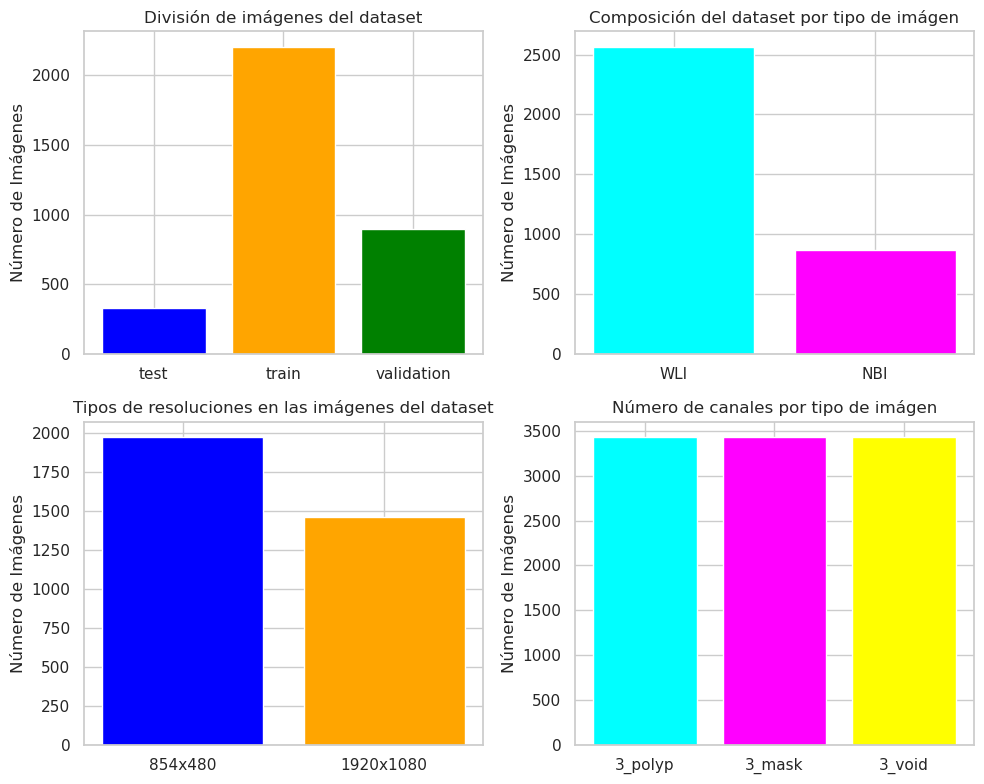

In [71]:
dt_Piccolo.graph_summmary()

## Kvasir-Seg

Este dataset clasifica los polipos con:
- Máscaras binarias
- Bounding boxes

In [72]:
# paths del dataset
paths_polyp_img = [("Kvasir-SEG/images", "polyp", "train")]

paths_mask_img = [("Kvasir-SEG/masks", "mask", "train")]

paths = paths_polyp_img + paths_mask_img

dt_Kevasir_SEG = Dataset()

# cargamos todos los paths
for path in paths:
    dt_Kevasir_SEG.load_dataset(path[0], path[1], path[2])

dt_Kevasir_SEG.print_summary()

Directorio "Kvasir-SEG/images" cargado con éxito
Directorio "Kvasir-SEG/masks" cargado con éxito
Total imágenes:
	- Polyp: 1000
	- Mask: 1000
	- Void: 0
Composición del dataset:
Formatos:
	WLI: 998	NBI: 2

Función:
	train: 1000

Resoluciónes: total distintas resoluciones 333
	622x529: 56	1348x1070: 17	619x529: 4	622x528: 53	617x528: 3	626x547: 66	621x530: 11	1214x1019: 1	570x531: 19	622x530: 78	611x530: 3	626x546: 61	622x531: 50	623x529: 8	609x546: 1	620x547: 1	594x528: 2	624x546: 1	607x530: 2	616x528: 6	571x530: 14	481x530: 1	560x529: 1	616x530: 7	621x528: 10	605x510: 1	623x528: 14	519x511: 1	459x526: 1	600x529: 2	622x511: 2	480x531: 1	619x528: 5	615x528: 2	622x547: 1	601x528: 2	549x530: 1	570x530: 33	536x530: 1	615x529: 3	577x505: 1	616x529: 4	612x546: 1	621x531: 9	590x529: 1	627x547: 5	617x513: 1	566x531: 1	619x547: 2	613x547: 1	572x547: 2	576x547: 1	570x521: 1	562x502: 1	568x529: 2	621x529: 12	611x529: 1	525x531: 1	605x529: 2	587x530: 2	490x531: 1	571x531: 10	576x530: 3	530x528: 1	

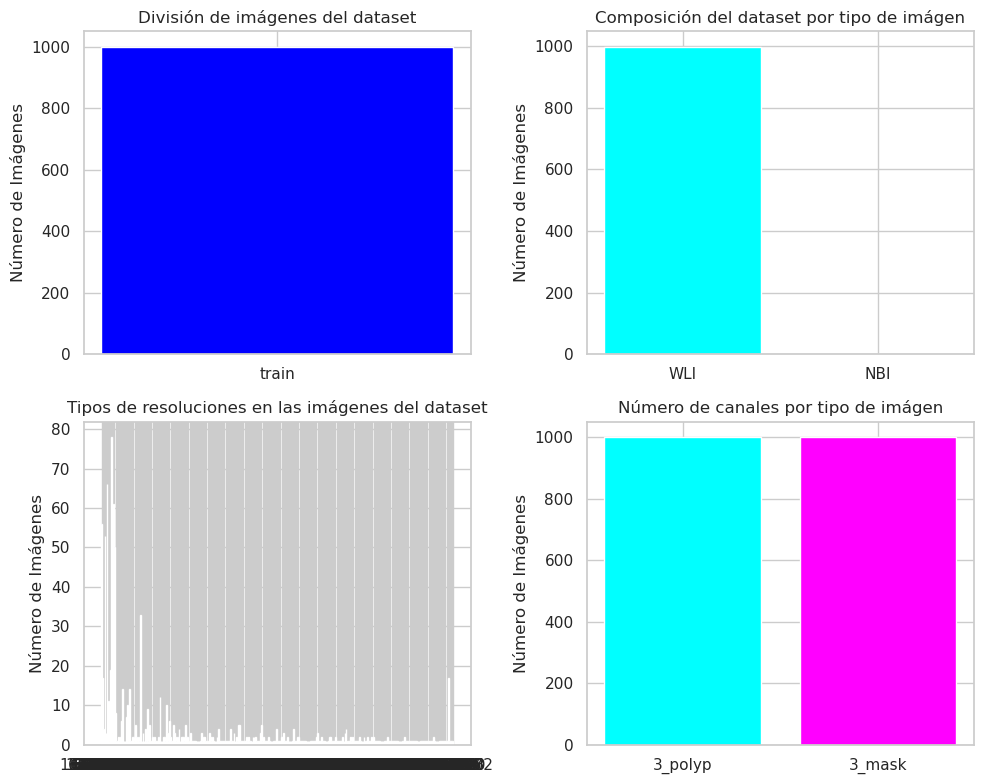

In [73]:
dt_Kevasir_SEG.graph_summmary()

## PolypDB
Este dataset se caracteriza por ser bastante completo y dar imágenes en formatos
muy distintos de imágen con los siguientes métodos para clasificar las imágenes:
- Máscara binaria

_Apuntar que cargo tan solo los datos de modality wise_

In [74]:
# paths del dataset
paths_polyp_img = [
    ("PolypDB/PolypDB_modality_wise/BLI/images", "polyp", "train", "BLI"),
    ("PolypDB/PolypDB_modality_wise/FICE/images", "polyp", "train", "FICE"),
    ("PolypDB/PolypDB_modality_wise/LCI/images", "polyp", "train", "LCI"),
    ("PolypDB/PolypDB_modality_wise/NBI/images", "polyp", "train", "NBI"),
    ("PolypDB/PolypDB_modality_wise/WLI/images", "polyp", "train", "WLI")]

paths_mask_img = [
    ("PolypDB/PolypDB_modality_wise/BLI/masks", "mask", "train", "BLI"),
    ("PolypDB/PolypDB_modality_wise/FICE/masks", "mask", "train", "FICE"),
    ("PolypDB/PolypDB_modality_wise/LCI/masks", "mask", "train", "LCI"),
    ("PolypDB/PolypDB_modality_wise/NBI/masks", "mask", "train", "NBI"),
    ("PolypDB/PolypDB_modality_wise/WLI/masks", "mask", "train", "WLI")]

paths = paths_polyp_img + paths_mask_img

dt_PolypDB = Dataset()

# cargamos todos los paths
for path in paths:
    dt_PolypDB.load_dataset(path[0], path[1], path[2], path[3])

dt_PolypDB.print_summary()

Error cargando PolypDB/PolypDB_modality_wise/BLI/images/.DS_Store
Directorio "PolypDB/PolypDB_modality_wise/BLI/images" cargado con éxito
Error cargando PolypDB/PolypDB_modality_wise/FICE/images/.DS_Store
Directorio "PolypDB/PolypDB_modality_wise/FICE/images" cargado con éxito
Error cargando PolypDB/PolypDB_modality_wise/LCI/images/.DS_Store
Directorio "PolypDB/PolypDB_modality_wise/LCI/images" cargado con éxito
Directorio "PolypDB/PolypDB_modality_wise/NBI/images" cargado con éxito
Directorio "PolypDB/PolypDB_modality_wise/WLI/images" cargado con éxito
Error cargando PolypDB/PolypDB_modality_wise/BLI/masks/.DS_Store
Directorio "PolypDB/PolypDB_modality_wise/BLI/masks" cargado con éxito
Error cargando PolypDB/PolypDB_modality_wise/FICE/masks/.DS_Store
Directorio "PolypDB/PolypDB_modality_wise/FICE/masks" cargado con éxito
Directorio "PolypDB/PolypDB_modality_wise/LCI/masks" cargado con éxito
Directorio "PolypDB/PolypDB_modality_wise/NBI/masks" cargado con éxito
Directorio "PolypDB/Poly

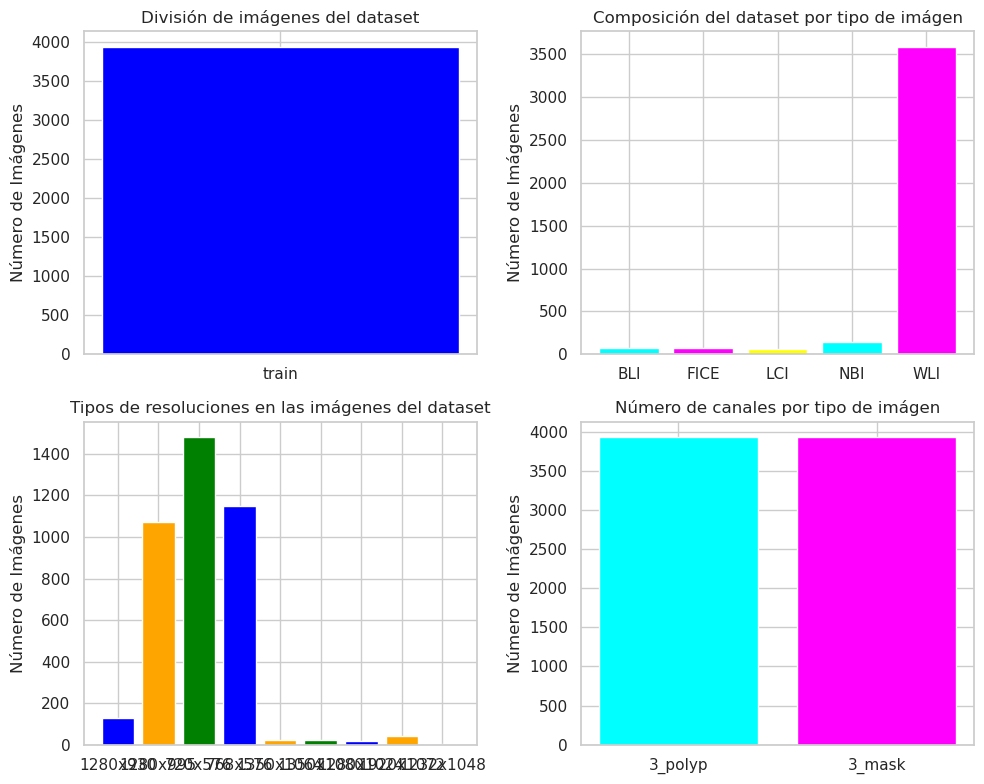

In [75]:
dt_PolypDB.graph_summmary()